## Trained model with raw input

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

# Define the Frozen Lake environment
states = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
num_states = len(states)
num_actions = 4

# Define the transition matrix
R = np.array([
    ['A', 'E', 'B', 'A'],
    ['B', 'F', 'C', 'A'],
    ['C', 'G', 'D', 'B'],
    ['D', 'H', 'D', 'C'],
    ['A', 'I', 'F', 'E'],
    ['B', 'J', 'G', 'E'],
    ['C', 'K', 'H', 'F'],
    ['D', 'L', 'H', 'G'],
    ['E', 'M', 'J', 'I'],
    ['F', 'N', 'K', 'I'],
    ['G', 'O', 'L', 'J'],
    ['H', 'P', 'L', 'K'],
    ['I', 'M', 'N', 'M'],
    ['J', 'N', 'O', 'M'],
    ['K', 'O', 'P', 'N'],
    ['L', 'P', 'P', 'O']
])
listOfHoles = np.array(['F', 'H', 'L', 'M'])

# Convert states to one-hot encoded vectors, ie: state A: (1, 0, 0, 0, 0, ... 0)
def state_to_one_hot(state):
    one_hot = np.zeros(num_states)
    one_hot[states.index(state)] = 1
    return one_hot

# Define the neural network model to approximate the value function
model = tf.keras.Sequential([
    layers.Input(shape=(num_states,)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output is the value of the state V(s)
])

model.compile(optimizer='adam', loss='mse')

In [ ]:
import numpy as np

# Function to evaluate the policy's rewards without feature extraction
def evaluate_policy_no_noise(network, epsilon=0.1, max_steps=100):
    total_reward = 0
    time_steps = 0

    # Start with the initial state and loop until reaching a terminal state or max_steps
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)  # Convert to one-hot input for the network
        time_steps += 1

        # Epsilon-greedy action selection: choose random action with probability epsilon
        if np.random.rand() < epsilon:
            best_action = np.random.randint(num_actions)  # Random action for exploration
        else:
            # Predict values for all possible actions and select the best action
            next_state_vectors = np.array([state_to_one_hot(R[state_index][a]) for a in range(num_actions)])
            action_values = network.predict(next_state_vectors)
            best_action = np.argmax(action_values)  # Select the action with the highest predicted value

        # Determine the next state based on the chosen action
        next_state = R[state_index][best_action]

        # Reward calculation
        reward = 0
        if next_state == 'P':  # Example: Goal state
            reward = 1
        elif next_state in listOfHoles:  # Example: Hole state
            reward = -10

        total_reward += reward

        # Stop if the goal (or terminal) state is reached
        if next_state == 'P' or time_steps >= max_steps:
            break

    return total_reward, time_steps


In [ ]:
import numpy as np
import random

# Function to evaluate the policy's rewards without noise and with epsilon-greedy policy
def evaluate_fe_policy_no_noise(network, epsilon=0.1, max_steps=100):
    total_reward = 0
    time_step = 0

    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Get features for the state

        # Choose action using epsilon-greedy strategy
        if random.random() < epsilon:
            best_action = random.randint(0, num_actions)  # Random action for exploration
        else:
            # Predict the values of all possible next states
            next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
            next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, feature_size)
            next_state_values = network.predict(next_state_features)  # Get predicted values

            best_action = np.argmax(next_state_values)  # Choose the best action based on predictions

        # Determine the next state based on the chosen action
        next_state = R[state_index][best_action]

        # Calculate the reward based on the next state
        reward = 0
        if next_state == 'P':  # Goal state
            reward = 1
        elif next_state in listOfHoles:  # Falling into a hole
            reward = -10

        total_reward += reward
        time_step += 1  # Increment time step for each action

        # Stop evaluation if the agent reaches the goal or max steps are reached
        if next_state == 'P' or time_step >= max_steps:
            break

    return total_reward, time_step


In [ ]:
# Hyperparameters
gamma = 0.9
num_iterations = 200
epsilon = 0.9
evaluation_interval = 1  # Evaluate policy every 20 iterations

# Lists to store evaluation metrics
reward_history = []
timestep_history = []

# Training loop
for iteration in range(num_iterations):
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)

        # Next state vectors for all actions
        next_state_vectors = np.array([state_to_one_hot(R[state_index][a]) for a in range(num_actions)])

        # Predict the values of all possible next states
        next_state_values = model.predict(next_state_vectors)

        # Calculate the target value using Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the model to output target value for the current state
        model.fit(state_vector.reshape(1, -1), np.array([target_value]), epochs=1, verbose=0)

    # Evaluate the policy every evaluation_interval iterations
    if iteration % evaluation_interval == 0:
        policy_reward, time_steps = evaluate_policy_no_noise(model, epsilon=epsilon)
        reward_history.append(policy_reward)
        timestep_history.append(time_steps)
        #print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {time_steps}")

        # Decay epsilon, ensuring it doesn't go below the min_epsilon
        epsilon = max(0.01, epsilon * 0.995)

print("Training complete.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

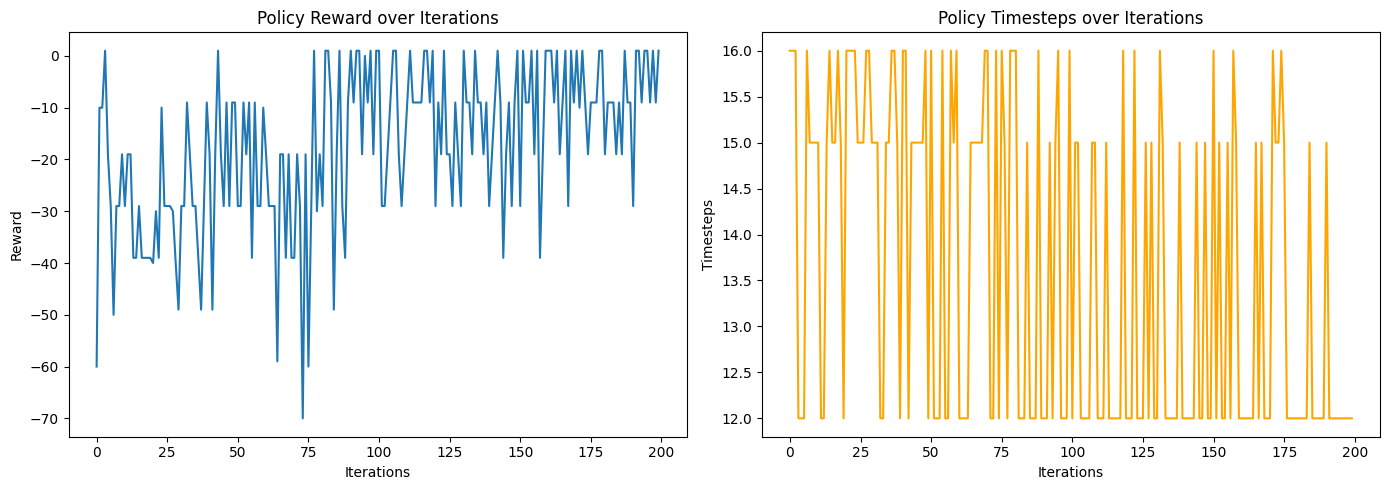

In [18]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(range(0, num_iterations, evaluation_interval), reward_history)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(range(0, num_iterations, evaluation_interval), timestep_history, color='orange')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps over Iterations')

plt.tight_layout()
plt.show()

In [ ]:
# Output the value V(s) for each state
print("State values after training:")
for state in states:
    state_vector = state_to_one_hot(state)
    state_vector_reshaped = state_vector.reshape(1, -1)  # Reshape for model input
    value = model.predict(state_vector_reshaped)[0][0]  # Get the predicted value
    print(f"V({state}) = {value:.2f}")

State values after training:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
V(A) = 5.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
V(B) = 6.03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
V(C) = 6.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(D) = 6.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(E) = 6.03
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
V(F) = -3.40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
V(G) = 7.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(H) = -3.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(I) = 6.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
V(J) = 7.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(K) = 8.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(L) = -0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
V(M) = -2.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
V(N) = 8.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
V(O) = 9.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
V(P) = 10.02


# Reduced Network: Use the activations of the first hidden layer as input

In [ ]:
# Step 1: Freeze the layers of the original model
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name)

dense
dense_1
dense_2
dense_3


In [ ]:
# Assuming your original model structure is something like this:
input_layer = layers.Input(shape=(num_states,))
first_hidden_layer_output = model.get_layer('dense').output

# Create the feature extraction model

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=first_hidden_layer_output)
# Create dummy data
dummy_input = np.random.random((1, num_states))

# Predict features using the feature extractor
try:
    features = feature_extractor.predict(dummy_input)
    print("Feature extraction successful. Output shape:", features.shape)
except Exception as e:
    print("Error during feature extraction:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Feature extraction successful. Output shape: (1, 32)


In [ ]:
state_features_dict = {}
for state in states:
    state_vector = state_to_one_hot(state).reshape(1, -1)
    print(state_vector)
    state_features = feature_extractor.predict(state_vector)
    print(state_features)
    state_features_dict[state] = state_features.reshape(-1)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[-0.16198969  0.00281385 -0.10475783  0.37638685  0.12123924 -0.2724343
  -0.2401954   0.0284544   0.00083487 -0.41178274  0.0026293   0.03811218
   0.30966285 -0.13899466 -0.04936484  0.14268634  0.3777643  -0.4078112
  -0.19435488 -0.19031104  0.32846773  0.3266427  -0.01309737  0.33928728
  -0.07119531 -0.05852825 -0.28260484  0.21229276 -0.24912637 -0.04250214
  -0.36235523 -0.40424544]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[ 0.20762247  0.27480072 -0.10558084 -0.28826597  0.16037399 -0.26856434
   0.1690773   0.00498795  0.17515741 -0.33510026 -0.18258815 -0.2907962
  -0.18799572  0.26599407  0.11881784 -0.23783582 -0.34372023 -0.22145583
   0.27544597  0.2794768   0.17592975  0.20227331  0.04247933 -0.1091397
   0.11130289  0.3095904   0.02592437  0.13491648 -0.22228973 -0.0947414
   0.06207063  0.2805338 ]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 

In [ ]:
# convert to 0 & 1
for state, features in state_features_dict.items():
    state_features_dict[state] = np.where(features > 0, 1, 0)

In [ ]:
for state in states:
    print(state_features_dict[state])

[0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
[1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1]
[0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1]
[1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
[1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0]
[1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0]
[0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1]
[1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1]
[1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0]
[1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0]
[0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]
[0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1]
[0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0]
[1 1 1 0 1

# A reduced sequential model with 2 hidden layer of 32

In [ ]:
# Define a new model using the extracted features
new_model_3 = tf.keras.Sequential([
    layers.Input(shape=(32,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

new_model_3.compile(optimizer='adam', loss='mse')

In [ ]:
# Training loop
for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values of all possible next states
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, 32)

        next_state_values = new_model_3.predict(next_state_features)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the new model to output target value for the current state
        new_model_3.fit(state_features, np.array([target_value]), epochs=1, verbose=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [ ]:
# Predict V values for all states
v_values = {}
for state, features in state_features_dict.items():
    features_reshaped = features.reshape(1, -1)  # Ensure correct shape
    v_value = new_model_3.predict(features_reshaped)
    v_values[state] = v_value[0][0]  # Extract the scalar value

# Print V values for each state
for state in states:
    print(f"State: {state}, V-value: {v_values[state]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
State: A, V-value: 5.178263187408447
State: B, V-value: 5.416557312011719
State: C, V-value: 6.118076801300049
State: D, V-value: 5.430536270141602
State: E, V-value: 5.472617149353027
State: F, V-value: -3.917304754257202
State: G, V-value: 6.989859104156494
State: H, V-value: -3.8025646209716797
State: I, V-value: 6.2449493408203125
State: J, V-value: 6.933045387268066
State: K, V-value: